In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = './dog-cat-data/train'
TEST_DIR = './dog-cat-data/test'
IMG_SIZE = 50
LR = 1e-3

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': 
        return [1,0]
    elif word_label == 'dog': 
        return [0,1]

In [12]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('./npy/train-data-dog-cat.npy', training_data)
    return training_data

In [14]:
# train_data = create_train_data()
train_data = np.load('./npy/train-data-dog-cat.npy')

In [5]:
import keras
import matplotlib.pyplot as plt
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import SimpleRNN
from keras import initializers
from keras.optimizers import RMSprop
from keras.models import load_model
from keras import regularizers

/home/ashish/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [7]:
train = train_data[:-500]
validate = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]
Y = np.array(Y)

validate_x = np.array([i[0] for i in validate]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
validate_y = [i[1] for i in validate]
validate_y = np.array(validate_y)

In [8]:
# # X[0][0]
# Y

In [9]:
cnn = get_model()
history = cnn.fit(X, Y, epochs=5, verbose = 1, validation_data=(validate_x, validate_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 28802     
Total params: 47,618
Trainable params: 47,618
Non-trainable params: 0
_________________________________________________________________
None
T

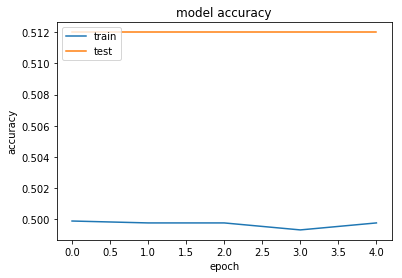

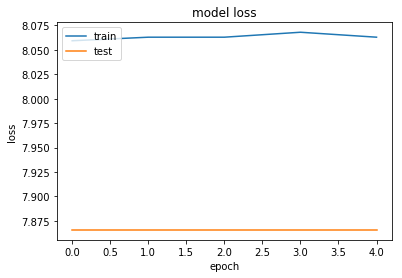

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("cnn_accuracy_table_epoch500_wrong_pros.jpg")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig("cnn_loss_table_epoch500_wrong_pros.jpg")
plt.show()

In [11]:
cnn.save("dog-cat-cnn.h5")

In [ ]:
def predict(filename, model):
    path = os.path.join(TEST_DIR, filename)
    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    img = np.array(img)
    data = img.reshape(-1, IMG_SIZE,IMG_SIZE,1)
    out = model.predict(data)

    if np.argmax(out) == 1: 
        str_label='Dog'
    else: 
        str_label='Cat'
    
    return str_label

In [ ]:
m = load_model("cnn_epoch500.h5")

In [ ]:
print(predict('517.jpg', m))

In [ ]:
import os
ctr_cat = 0
ctr_dog = 0

# for i in range(1, len(os.listdir(TEST_DIR))):
for i in range(1, 100):
    o = predict(str(i) + '.jpg', m)
#     print(o)
    if o == 'Cat':
        ctr_cat += 1
    else:
        ctr_dog += 1
        
print("ctr_cat, ctr_dog", ctr_cat, ctr_dog)